这篇教程将重点讨论图像分割任务，使用的是改进版的U-Net。

什么是图像分割？<br>
但是，有时你想知道一个物体在一张图像中的位置，这个物体的形状，以及其中一部分属于这样的情况下你会希望分割图像，也就是给图像中的每个指针各分配一个标签。因此，图像分割的任务是训练一个神经网络来输出该图像对每个一个的的掩盖。编码。这对从更剧烈的变化，即转化层级，来理解图像很有帮助。图像分割在例如医疗图像，自动驾驶车辆以及卫星图像等领域有很多应用。

本教程将使用的数据集是Oxford-IIIT Pet数据集，由Parkhi 等创建。该数据集由图像，图像所对应的标签，以及对逐一标记的片段组成。 *类别1：作为是宠物的一部分。*类别2：代表是宠物的轮廓。*类别3：以上都不是/较长的时间。

In [1]:
# !pip install -q git+https://github.com/tensorflow/examples.git

^C


In [4]:
import tensorflow as tf

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

下载Oxford-IIIT宠物数据集<br>
这个数据集已经集成在Tensorflow数据集中，只需下载即可。图像分割延迟在版本3.0.0中才被加入，因此我们特别替换这个版本。

In [8]:
dataset, info = tfds.load('oxford_iiit_pet:3.0.0', with_info=True)

然后，将图像标准化到[0,1]。最后，如上文提到的，将点在图像上分割成中被标记为{1，2，3}中的一个。为了方便起见，我们将分割分区都减1，得到了以下的标签：{0，1，2}。

In [9]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32)/128.0 - 1
    input_mask -= 1
    return input_image, input_mask

In [10]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [11]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

数据集已经包含了所需的测试集和训练集划分，所以我们也延续使用相同的划分。

In [12]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [13]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [14]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

我们来看一下数据集中的一例图像以及它所对应的细分。

In [15]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

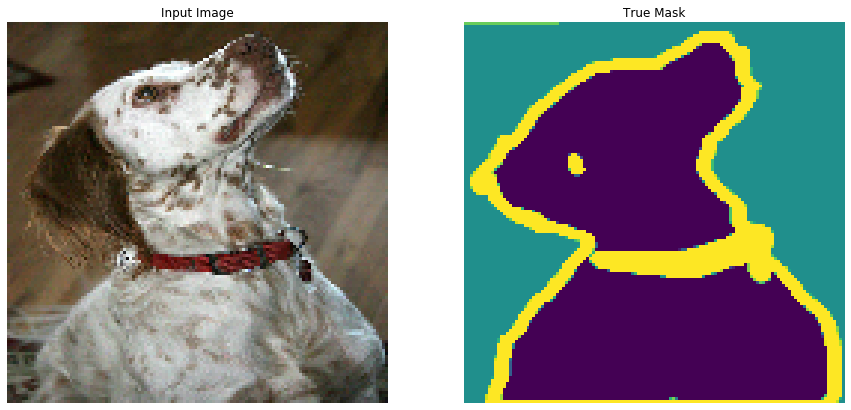

In [16]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

定义模型<br>
U-Net由一个编码器（下采样器（downsampler））和一个解码器（上采样器（upsampler））组成。为了学习到鲁棒的特征，同时减少可训练参数的数量，这里可以使用一个预训练模型作为编码器。因此，此任务中的编码器将使用一个预训练的MobileNetV2模型，它的中间输出值将被使用。解码器将使用在TensorFlow示例中的Pix2pix教程里实现过的升频采样模块。

输出信道数量为3是因为每个预期都有某种可能的标签。把这想象成一个多类别分类，每个指出都将被分到三个类别当中。

In [17]:
OUTPUT_CHANNELS = 3

如之前提到的，编码器是一个预训练的MobileNetV2模型，它在tf.keras.applications中已被准备好并可以直接使用。编码器中包含模型中间层的某些特定输出。注意编码器在模型的训练过程中是不会被训练的。

In [19]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# 使用这些层的激活设置
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# 创建特征提取模型
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

解码器/升频采样器是简单的多个升频采样模块，在TensorFlow示例中曾被实施过。

In [20]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [21]:
def unet_model(output_channels):

    # 这是模型的最后一层
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # 在模型中降频取样
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # 升频取样然后建立跳跃连接
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

训练模型<br>
现在，要做的只剩下编译和训练模型了。这里用到的损失函数是loss.sparse_categorical_crossentropy。使用这个损失函数是因为神经网络试图给每一个分配一个标签，和多类别预测是一样的。在正确的分割长度中，每个预期点的值是{0,1,2}中的一个。同时神经网络也输出三个信道。本质上，每个信道都在尝试学习预测一个类别，而loss.sparse_categorical_crossentropy正是这一阶段下推荐使用的损失函数。根据神经网络的输出值，分配给每个变量的标签为输出值最高的传输所表示的那一类。这就是create_mask函数进行的工作。

In [22]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

我们试着运行一下模型，看看它在训练之前指定的预测值。

In [23]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [24]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

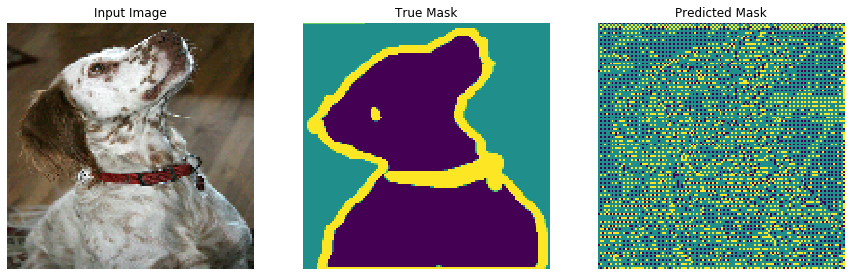

In [25]:
show_predictions()

为达成这一目的，下面将定义一个回调函数。

In [26]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

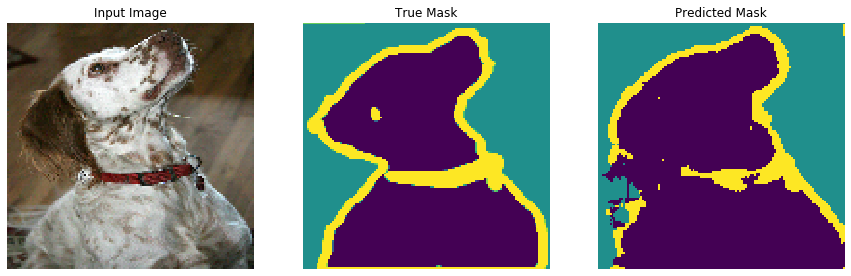


Sample Prediction after epoch 20

57/57 [==============================] - 12s 208ms/step - loss: 0.1403 - accuracy: 0.9362 - val_loss: 0.3586 - val_accuracy: 0.8789


In [27]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

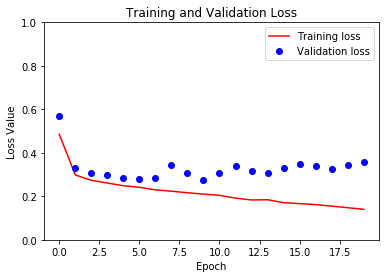

In [28]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

做出预测<br>
我们来做几个预测。为了节省时间，这里只使用很少的周期（epoch）数，但是您可以设置更多的数量并更准确的结果。

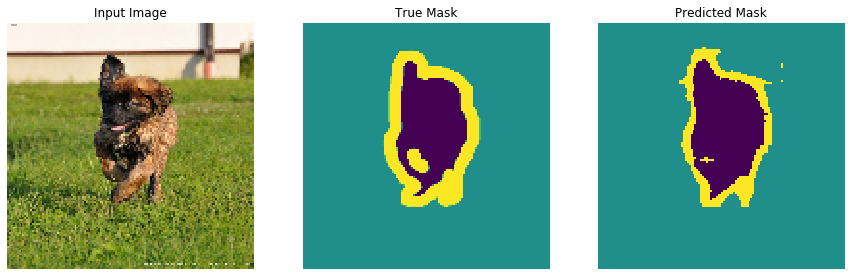

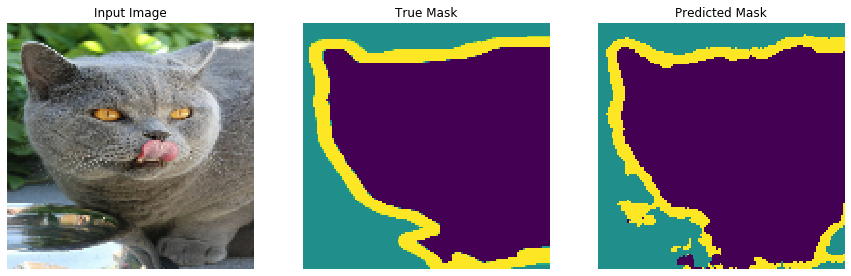

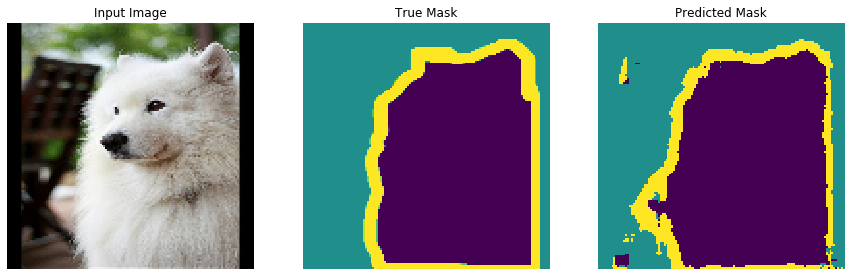

In [29]:
show_predictions(test_dataset, 3)

接下来<br>
现在你已经对图像分割是什么以及它的工作原理有所了解。你可以在本教程里尝试使用不同的中间层输出值，或者甚至使用不同的预训练模型。你也可以去Kaggle举行的Carvana图像分割挑战赛上挑战自己。

你也可以看看Tensorflow对象检测API上面的其他你可以使用自己数据进行再训练的模型。